In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#with shuffle and the predifined xgb
import pandas as pd
import numpy as np
import nltk
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import joblib
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import xgboost as xgb
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()

    # Convert POS tag to WordNet format
    def get_wordnet_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

    lemmas = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]

    return lemmas

def preprocessing(text):
    lower_text = text.lower()

    # Remove punctuation
    punctuation_free = "".join([char for char in lower_text if char not in string.punctuation])

    # Remove URLs
    remove_urls = re.sub(r'http\S+', '', punctuation_free)

    # Remove digits
    remove_digits = re.sub(r'\d', '', remove_urls)

    # Tokenize text
    tokenized_text = word_tokenize(remove_digits)

    # Remove stop words
    filtered_tokens = [token for token in tokenized_text if token not in stop_words]

    # Lemmatize tokens
    lemmatized_tokens = lemmatize_tokens(filtered_tokens)

    return ' '.join(lemmatized_tokens)  # Join tokens back into a single string

X_augmented = joblib.load('/content/drive/My Drive/Master_Thesis/X_augmented.pkl')
y_augmented = joblib.load('/content/drive/My Drive/Master_Thesis/y_augmented.pkl')
X_train = joblib.load('/content/drive/My Drive/Master_Thesis/X_train.pkl')
y_train = joblib.load('/content/drive/My Drive/Master_Thesis/y_train.pkl')
X_test = joblib.load('/content/drive/My Drive/Master_Thesis/X_test.pkl')
y_test = joblib.load('/content/drive/My Drive/Master_Thesis/y_test.pkl')

# Concatenate X_train and X_augmented
X_combined = pd.concat([X_train, pd.Series(X_augmented)], ignore_index=True)

# Combine y_train and y_augmented
y_combined = np.concatenate([y_train, np.array(y_augmented)])

# Ensure y_combined is a numpy array
if not isinstance(y_combined, np.ndarray):
    raise TypeError("y_combined is not a numpy array.")

# Shuffle X_combined and y_combined together
X_combined, y_combined = shuffle(X_combined, y_combined, random_state=42)

# Check the first rows of X_combined
print("First few rows of X_combined:")
print(X_combined.head())

# Ensure X_combined Series
if not isinstance(X_combined, pd.Series):
    raise TypeError("X_combined is not a Series.")

# TF-IDF Vectorizer pipeline
tfidf_data_augmented = Pipeline([
    ('tfidf', TfidfVectorizer(
        tokenizer=preprocessing,     # Custom preprocessing function
        stop_words='english',        # Remove English stopwords
        ngram_range=(1, 1)           # Consider only unigrams
    ))
])

# Fit and transform the combined data
X_combined_tfidf = tfidf_data_augmented.fit_transform(X_combined)
X_test_tfidf = tfidf_data_augmented.transform(X_test)

# Check the shapes of TF-IDF matrices
print("Number of features in X_combined_tfidf:", X_combined_tfidf.shape[1])
print("Number of features in X_test_tfidf:", X_test_tfidf.shape[1])

# Compute sample weights for handling imbalance
sample_weights = compute_sample_weight(class_weight='balanced', y=y_combined)

# Define best params for XGBClassifier
best_xgb_params = {
    'n_estimators': 120,
    'min_child_weight': 1,
    'max_depth': 5,
    'learning_rate': 0.23,
    'lambda': 0.04,
    'gamma': 0.7,
    'alpha': 0.1
}

# Create XGBClassifier with the best pars
best_xgb_classifier = xgb.XGBClassifier(**best_xgb_params)

best_xgb_classifier.fit(X_combined_tfidf, y_combined, sample_weight=sample_weights)

y_pred = best_xgb_classifier.predict(X_test_tfidf)

classification_rep = classification_report(y_test, y_pred)
print(classification_rep)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


First few rows of X_combined:
150      i am sorry, but the text "jessicafilan it is" ...
6887     i had a rough day today. it felt like everythi...
13077    i just can't shake this feeling of dread that ...
9513     i feel overwhelmed and torn between two confli...
9666     i find myself in the same boat every night, dr...
dtype: object


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn(


Number of features in X_combined_tfidf: 42
Number of features in X_test_tfidf: 42
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       780
           1       0.35      0.42      0.38       252
           2       0.46      0.38      0.41       279
           3       0.53      0.46      0.50       236

    accuracy                           0.65      1547
   macro avg       0.55      0.54      0.54      1547
weighted avg       0.65      0.65      0.65      1547



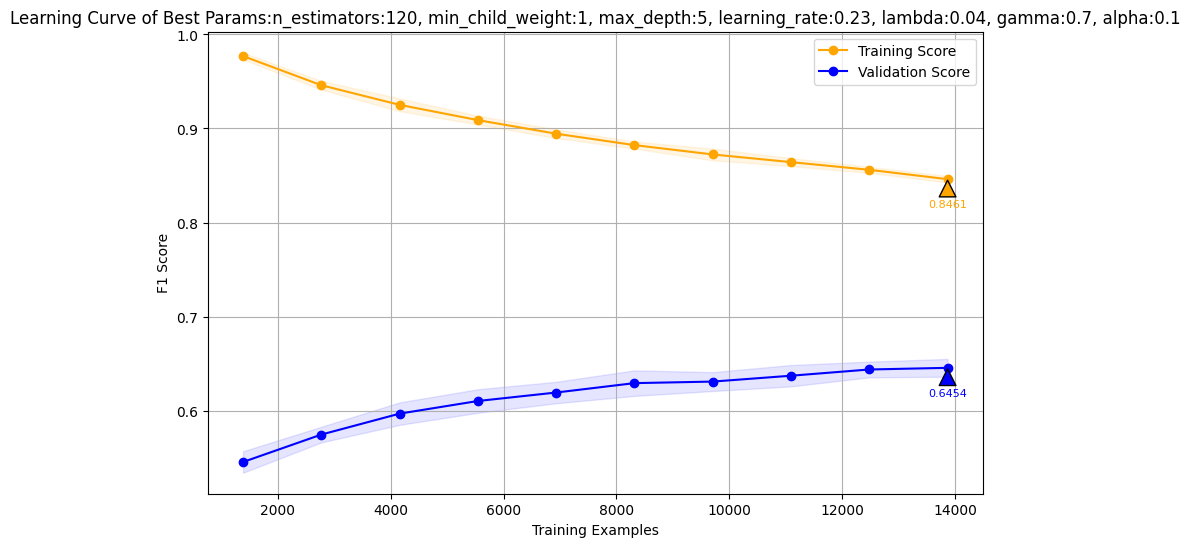

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Plot learning curve
train_sizes, train_scores, valid_scores = learning_curve(
    best_xgb_classifier, X_combined_tfidf, y_combined,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='f1_weighted', cv=10, shuffle=True)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

# Print final F1 scores for training and validation
final_train_f1_mean = train_scores_mean[-1]
final_valid_f1_mean = valid_scores_mean[-1]

plt.figure(figsize=(10, 6))
plt.title('Learning Curve of Best Params:n_estimators:120, min_child_weight:1, max_depth:5, learning_rate:0.23, lambda:0.04, gamma:0.7, alpha:0.1')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="orange")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.1, color="blue")
plt.plot(train_sizes, train_scores_mean, 'o-', color="orange", label="Training Score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="blue", label="Validation Score")
# Add annotations for the final F1 scores
plt.annotate(f'{final_train_f1_mean:.4f}',
             xy=(train_sizes[-1], final_train_f1_mean),
             xytext=(train_sizes[-1], final_train_f1_mean- 0.03),
             arrowprops=dict(facecolor='orange', shrink=0.05),
             fontsize=8, color='orange', ha='center')

plt.annotate(f'{final_valid_f1_mean:.4f}',
             xy=(train_sizes[-1], final_valid_f1_mean),
             xytext=(train_sizes[-1], final_valid_f1_mean- 0.03),
             arrowprops=dict(facecolor='blue', shrink=0.05),
             fontsize=8, color='blue', ha='center')

plt.legend(loc="best")
plt.grid()
#plt.savefig('/content/drive/My Drive/Master_Thesis/learning_curve_best_params_XGBoost.png')  # Save the plot with filename based on class number

plt.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', '

First few rows of X_combined:
2996    i want to hear the new eminem single "we made ...
6879    i constantly feel like i should just disappear...
6740    i thought i had discovered a hidden gem with "...
3509    i watch videos of people dying before going to...
764     i am so disappointed that your t i party is wh...
dtype: object
Number of features in X_combined_tfidf: 42
Number of features in X_test_tfidf: 42
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       780
           1       0.34      0.40      0.37       252
           2       0.46      0.34      0.39       279
           3       0.48      0.44      0.46       236

    accuracy                           0.64      1547
   macro avg       0.53      0.52      0.52      1547
weighted avg       0.63      0.64      0.63      1547



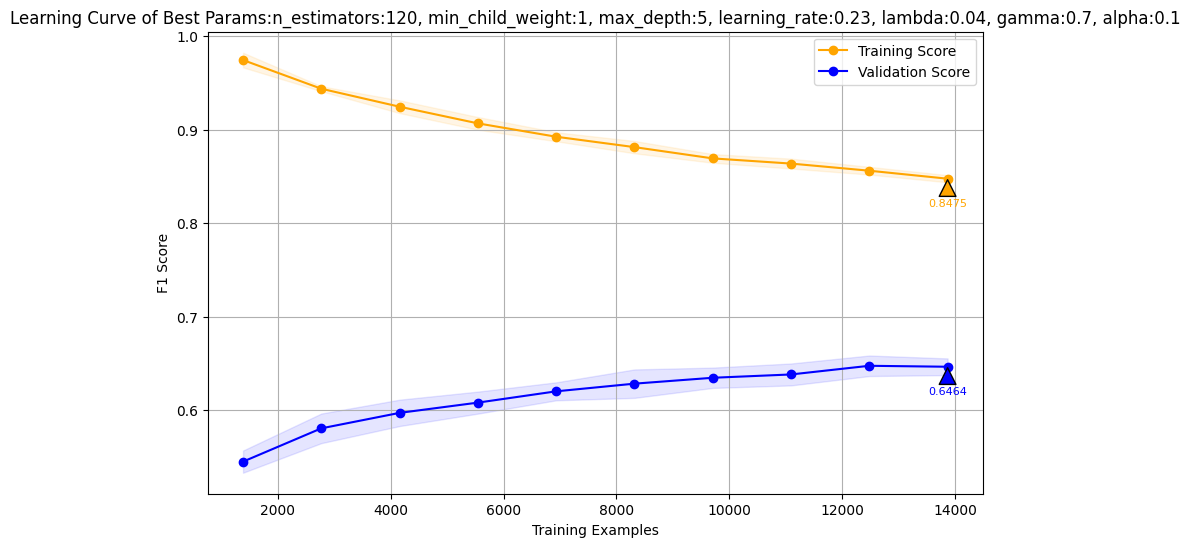

In [ ]:
import pandas as pd
import numpy as np
import nltk
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import joblib
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import xgboost as xgb

# Download NLTK resources (if not already downloaded)
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# Import NLTK English stopwords
stop_words = set(stopwords.words('english'))

# Define lemmatization function
def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()

    # Convert POS tag to WordNet format
    def get_wordnet_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

    # Lemmatize tokens
    lemmas = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]

    # Return lemmatized tokens as a list
    return lemmas

# Function to remove sentences with specific phrases
def remove_unwanted_sentences(text):
    unwanted_phrase = "i am sorry, but the text"
    sentences = nltk.sent_tokenize(text)
    filtered_sentences = [sentence for sentence in sentences if unwanted_phrase.lower() not in sentence.lower()]
    return ' '.join(filtered_sentences)

# preprocessing function
def preprocessing(text):
    # Remove sentences with the unwanted phrase
    text = remove_unwanted_sentences(text)

    # Convert text to lowercase
    lower_text = text.lower()

    # Remove punctuation
    punctuation_free = "".join([char for char in lower_text if char not in string.punctuation])

    # Remove URLs
    remove_urls = re.sub(r'http\S+', '', punctuation_free)

    # Remove digits
    remove_digits = re.sub(r'\d', '', remove_urls)

    # Tokenize text
    tokenized_text = word_tokenize(remove_digits)

    # Remove stop words
    filtered_tokens = [token for token in tokenized_text if token not in stop_words]

    # Lemmatize tokens
    lemmatized_tokens = lemmatize_tokens(filtered_tokens)

    return ' '.join(lemmatized_tokens)  # Join tokens back into a single string

# Load data
X_augmented = joblib.load('/content/drive/My Drive/Master_Thesis/X_augmented.pkl')
y_augmented = joblib.load('/content/drive/My Drive/Master_Thesis/y_augmented.pkl')
X_train = joblib.load('/content/drive/My Drive/Master_Thesis/X_train.pkl')
y_train = joblib.load('/content/drive/My Drive/Master_Thesis/y_train.pkl')
X_test = joblib.load('/content/drive/My Drive/Master_Thesis/X_test.pkl')
y_test = joblib.load('/content/drive/My Drive/Master_Thesis/y_test.pkl')

# Filter out unwanted sentences from X_augmented and X_train
X_augmented_filtered = [x for x, y in zip(X_augmented, y_augmented) if "i am sorry, but the text" not in x]
y_augmented_filtered = [y for x, y in zip(X_augmented, y_augmented) if "i am sorry, but the text" not in x]
X_train_filtered = [x for x, y in zip(X_train, y_train) if "i am sorry, but the text" not in x]
y_train_filtered = [y for x, y in zip(X_train, y_train) if "i am sorry, but the text" not in x]

# Concatenate X_train and X_augmented
X_combined = pd.concat([pd.Series(X_train_filtered), pd.Series(X_augmented_filtered)], ignore_index=True)

# Combine y_train and y_augmented
y_combined = np.concatenate([y_train_filtered, y_augmented_filtered])

# Ensure y_combined is a numpy array
if not isinstance(y_combined, np.ndarray):
    raise TypeError("y_combined is not a numpy array.")

# Shuffle X_combined and y_combined together
X_combined, y_combined = shuffle(X_combined, y_combined, random_state=42)

# Check the first few rows of X_combined
print("First few rows of X_combined:")
print(X_combined.head())

# Ensure X_combined is a Series
if not isinstance(X_combined, pd.Series):
    raise TypeError("X_combined is not a Series.")

# Define TF-IDF Vectorizer pipeline
tfidf_data_augmented = Pipeline([
    ('tfidf', TfidfVectorizer(
        tokenizer=preprocessing,     # Custom preprocessing function
        stop_words='english',        # Remove English stopwords
        ngram_range=(1, 1)           # Consider only unigrams
    ))
])

# Fit and transform the combined data
X_combined_tfidf = tfidf_data_augmented.fit_transform(X_combined)
X_test_tfidf = tfidf_data_augmented.transform(X_test)

# Check the shapes of TF-IDF matrices
print("Number of features in X_combined_tfidf:", X_combined_tfidf.shape[1])
print("Number of features in X_test_tfidf:", X_test_tfidf.shape[1])

# Compute sample weights for handling class imbalance
sample_weights = compute_sample_weight(class_weight='balanced', y=y_combined)

# Define the best parameters for XGBClassifier
best_xgb_params = {
    'n_estimators': 120,
    'min_child_weight': 1,
    'max_depth': 5,
    'learning_rate': 0.23,
    'lambda': 0.04,
    'gamma': 0.7,
    'alpha': 0.1
}

# Create XGBClassifier with the best parameters
best_xgb_classifier = xgb.XGBClassifier(**best_xgb_params)

# Fit the model with the transformed training data
best_xgb_classifier.fit(X_combined_tfidf, y_combined, sample_weight=sample_weights)

# Make predictions on the test data
y_pred = best_xgb_classifier.predict(X_test_tfidf)

# Print the classification report
classification_rep = classification_report(y_test, y_pred)
print(classification_rep)
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Assuming best_xgb_classifier is defined and trained
# Plot learning curve
train_sizes, train_scores, valid_scores = learning_curve(
    best_xgb_classifier, X_combined_tfidf, y_combined,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='f1_weighted', cv=10, shuffle=True)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

# Print final F1 scores for training and validation
final_train_f1_mean = train_scores_mean[-1]
final_valid_f1_mean = valid_scores_mean[-1]

plt.figure(figsize=(10, 6))
plt.title('Learning Curve of Best Params:n_estimators:120, min_child_weight:1, max_depth:5, learning_rate:0.23, lambda:0.04, gamma:0.7, alpha:0.1')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="orange")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.1, color="blue")
plt.plot(train_sizes, train_scores_mean, 'o-', color="orange", label="Training Score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="blue", label="Validation Score")
# Add annotations for the final F1 scores
plt.annotate(f'{final_train_f1_mean:.4f}',
             xy=(train_sizes[-1], final_train_f1_mean),
             xytext=(train_sizes[-1], final_train_f1_mean- 0.03),
             arrowprops=dict(facecolor='orange', shrink=0.05),
             fontsize=8, color='orange', ha='center')

plt.annotate(f'{final_valid_f1_mean:.4f}',
             xy=(train_sizes[-1], final_valid_f1_mean),
             xytext=(train_sizes[-1], final_valid_f1_mean- 0.03),
             arrowprops=dict(facecolor='blue', shrink=0.05),
             fontsize=8, color='blue', ha='center')

plt.legend(loc="best")
plt.grid()
#plt.savefig('/content/drive/My Drive/Master_Thesis/learning_curve_best_params_XGBoost.png')  # Save the plot with filename based on class number

plt.show()

In [ ]:
import pandas as pd
import numpy as np
import nltk
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import joblib
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Define lemmatization function
def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()

    # Convert POS tag to WordNet format
    def get_wordnet_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

    # Lemmatize tokens
    lemmas = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]

    # Return lemmatized tokens as a list
    return lemmas

# Function to remove sentences with specific phrases
def remove_unwanted_sentences(text):
    unwanted_phrase = "i am sorry, but the text"
    sentences = nltk.sent_tokenize(text)
    filtered_sentences = [sentence for sentence in sentences if unwanted_phrase.lower() not in sentence.lower()]
    return ' '.join(filtered_sentences)

#  preprocessing function
def preprocessing(text):
    # Remove sentences with the unwanted phrase
    text = remove_unwanted_sentences(text)

    # Convert text to lowercase
    lower_text = text.lower()

    # Remove punctuation
    punctuation_free = "".join([char for char in lower_text if char not in string.punctuation])

    # Remove URLs
    remove_urls = re.sub(r'http\S+', '', punctuation_free)

    # Remove digits
    remove_digits = re.sub(r'\d', '', remove_urls)

    # Tokenize text
    tokenized_text = word_tokenize(remove_digits)

    # Remove stop words
    filtered_tokens = [token for token in tokenized_text if token not in stop_words]

    # Lemmatize tokens
    lemmatized_tokens = lemmatize_tokens(filtered_tokens)

    return ' '.join(lemmatized_tokens)  # Join tokens back into a single string

X_augmented = joblib.load('/content/drive/My Drive/Master_Thesis/X_augmented.pkl')
y_augmented = joblib.load('/content/drive/My Drive/Master_Thesis/y_augmented.pkl')
X_train = joblib.load('/content/drive/My Drive/Master_Thesis/X_train.pkl')
y_train = joblib.load('/content/drive/My Drive/Master_Thesis/y_train.pkl')
X_test = joblib.load('/content/drive/My Drive/Master_Thesis/X_test.pkl')
y_test = joblib.load('/content/drive/My Drive/Master_Thesis/y_test.pkl')

# Filter out unwanted sentences from X_augmented and X_train
X_augmented_filtered = [x for x, y in zip(X_augmented, y_augmented) if "i am sorry, but the text" not in x]
y_augmented_filtered = [y for x, y in zip(X_augmented, y_augmented) if "i am sorry, but the text" not in x]
X_train_filtered = [x for x, y in zip(X_train, y_train) if "i am sorry, but the text" not in x]
y_train_filtered = [y for x, y in zip(X_train, y_train) if "i am sorry, but the text" not in x]

# Concatenate X_train and X_augmented
X_combined = pd.concat([pd.Series(X_train_filtered), pd.Series(X_augmented_filtered)], ignore_index=True)

# Combine y_train and y_augmented
y_combined = np.concatenate([y_train_filtered, y_augmented_filtered])

# Ensure y_combined is a numpy array
if not isinstance(y_combined, np.ndarray):
    raise TypeError("y_combined is not a numpy array.")

# Shuffle X_combined and y_combined together
X_combined, y_combined = shuffle(X_combined, y_combined, random_state=42)

# Check the first few rows of X_combined
print("First few rows of X_combined:")
print(X_combined.head())

# Ensure X_combined is a Series
if not isinstance(X_combined, pd.Series):
    raise TypeError("X_combined is not a Series.")
# Check the first few rows of X_combined
print("First few rows of X_combined:")
print(X_combined.head())

# Ensure X_combined is a Series
if not isinstance(X_combined, pd.Series):
    raise TypeError("X_combined is not a Series.")

# Define TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,     # Custom preprocessing function
    stop_words='english',        # Remove English stopwords
    ngram_range=(1, 1)           # Consider only unigrams
)

# Fit and transform the combined data
X_combined_tfidf = tfidf_vectorizer.fit_transform(X_combined)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Check the shapes of TF-IDF matrices
print("Number of features in X_combined_tfidf:", X_combined_tfidf.shape[1])
print("Number of features in X_test_tfidf:", X_test_tfidf.shape[1])



# Assuming X_train_tfidf, y_train, X_test, and y_test are already defined

# Compute sample weights for imbalanced classes
#sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

param_dist = {
    'learning_rate': [0.01, 0.05, 0.016, 0.08, 0.16, 0.23, 0.3],
    'n_estimators': [120, 195],
    'max_depth': [3, 4, 5],
    'gamma': [0, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'min_child_weight': [1, 3, 5, 7],
    'alpha': [0, 0.1, 0.5, 1],
    'lambda': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1, 1]
}

xgb_classifier = XGBClassifier(objective='multi:softprob')

# Perform Randomized Search CV with F1 scoring
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_classifier,
    param_distributions=param_dist,
    n_iter=100,
    scoring='f1_weighted',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

# Fit the XGBoost classifier with training data and sample weights
xgb_random_search.fit(X_combined_tfidf, y_combined)

# Print the best F1 score and best parameters
print("Best F1 Score: %f using %s" % (xgb_random_search.best_score_, xgb_random_search.best_params_))

# Extract the best parameters
best_xgb_params = xgb_random_search.best_params_

# Print the best parameters
print("Best parameters found: ", best_xgb_params)

# Create XGBClassifier with the best parameters
best_xgb_classifier = xgb.XGBClassifier(**best_xgb_params)

# Fit the model with the transformed training data
best_xgb_classifier.fit(X_combined_tfidf, y_combined)
# Make predictions on the test data
y_pred = best_xgb_classifier.predict(X_test_tfidf)

# Print the classification report
classification_rep = classification_report(y_test, y_pred)
print(classification_rep)

First few rows of X_combined:
2996    i want to hear the new eminem single "we made ...
6879    i constantly feel like i should just disappear...
6740    i thought i had discovered a hidden gem with "...
3509    i watch videos of people dying before going to...
764     i am so disappointed that your t i party is wh...
dtype: object
First few rows of X_combined:
2996    i want to hear the new eminem single "we made ...
6879    i constantly feel like i should just disappear...
6740    i thought i had discovered a hidden gem with "...
3509    i watch videos of people dying before going to...
764     i am so disappointed that your t i party is wh...
dtype: object


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', '

Number of features in X_combined_tfidf: 42
Number of features in X_test_tfidf: 42
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best F1 Score: 0.672838 using {'n_estimators': 195, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.3, 'lambda': 0.04, 'gamma': 0.06, 'alpha': 1}
Best parameters found:  {'n_estimators': 195, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.3, 'lambda': 0.04, 'gamma': 0.06, 'alpha': 1}
              precision    recall  f1-score   support

           0       0.84      0.89      0.87       780
           1       0.35      0.38      0.36       252
           2       0.47      0.41      0.43       279
           3       0.49      0.42      0.45       236

    accuracy                           0.65      1547
   macro avg       0.54      0.52      0.53      1547
weighted avg       0.64      0.65      0.64      1547



In [ ]:
#from here

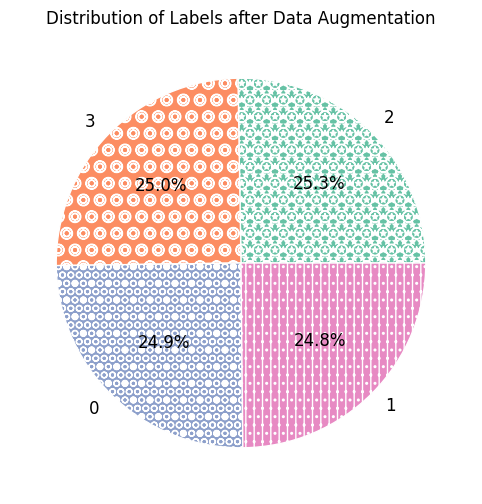

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

label_counts = y_combined['labels'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=label_counts.index, wedgeprops={"linewidth": 1, "edgecolor": "white"}, textprops={'fontsize': 12},autopct='%1.1f%%', colors=sns.color_palette("Set2"), hatch=['**O', 'oO', 'O.O', '.||.'])
plt.title('Distribution of Labels after Data Augmentation')
plt.savefig('/content/drive/My Drive/Master_Thesis/Distribution_of_Labels_after_Data_Augmentation.png')
plt.show()

